## Load all the scripts
Here, all the modules are called using the _import-ipynb_ librairy. To install, use command :
``` python
!pip install import-ipynb 
```

This imports all the functions to this notebook

In [3]:
#load all the functions from other scripts
import import_ipynb
%run IP/IP_methods.ipynb #Image processing script

%run PathPlanning.ipynb # Path Planning script


# __1) Vision__
Here are called all the function related to the vision of this project.
## Constants and parameters

In [4]:
#folder name where the generated files will be stored
Path_to_MAP = 'output'

#whether to plot the vision outputs or not
plot_vis = False

## Call to functions
Here, only one top level function is needed. The image and the needed to be put in correct places. The start position and angle are returned as variables for easy access throughout the code

In [88]:
(x,y), orientation = pipeline_IP(plot_vis)
start = [x,y]

# __2) Path Planning__
## Constants and variables
The constants are named in all caps for easy identification. They should never change during the code.

In [5]:
#thymio radius 95 mm between the wheels
RADIUS = 40

#A0 size 841 x 1188 mm
XSIZE = 2*841
YSIZE = 1188
DESIRED_SIZE=[XSIZE, YSIZE]

CORR_FACT = 35

# Variables
epsilon_path_plan =  2000 # If the thymio chooses to exit the map, increase
smoothing_factor= 0.01 # smoothing factor, smaller is more smooth
csvPath = Path_to_MAP + "/obst.csv"
savePath = Path_to_MAP + "/csvIM.png"

goalPath = Path_to_MAP + "/goal.csv"
goalsavePath = Path_to_MAP + "/csvIM_goal.png"

graph_name = Path_to_MAP + '/graph'

plot_pp = True
verbose_pp = False

## Call to functions
The offline part is only called at the start to build the vision graph. Here the online part is also called, but can be called again during the rest of the code with a new starting position.

In [7]:
start = [143, 17]
[xs, ys] = np.genfromtxt(csvPath, delimiter=',').shape
startx = (start[0]-CORR_FACT)*XSIZE/(xs)
starty = start[1]*YSIZE/ys
start = [startx, starty]
goal = PathPlanning_offline(graph_name, csvPath, savePath, goalPath, goalsavePath, DESIRED_SIZE, 
                         smoothing_factor, RADIUS, epsilon_path_plan, plot_pp, verbose_pp)
path, inObstacle = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, plot_pp, verbose_pp)

100%|██████████| 4/4 [00:00<00:00, 30.78it/s]

Thymio in an obstacle, no new path computed


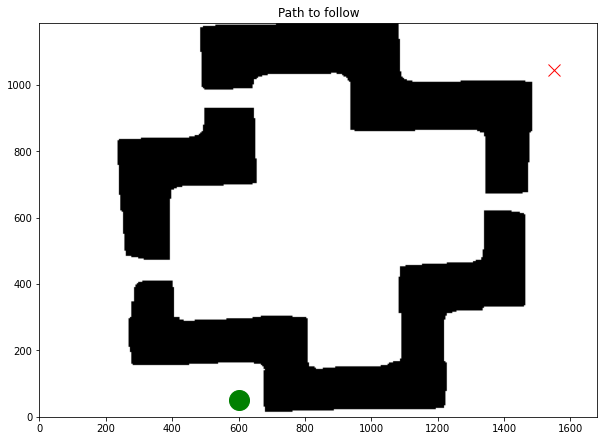

In [72]:
img = cv2.imread(savePath)
fig = plt.figure(figsize=(10,10))
plt.title("Path to follow")
plt.imshow(img, aspect = 'equal',origin = 'lower')
plt.plot(start[0], start[1], color = 'green', markersize=RADIUS/2 ,marker='o')
plt.plot(goal[0], goal[1], color = 'red', markersize=12 ,marker='x')

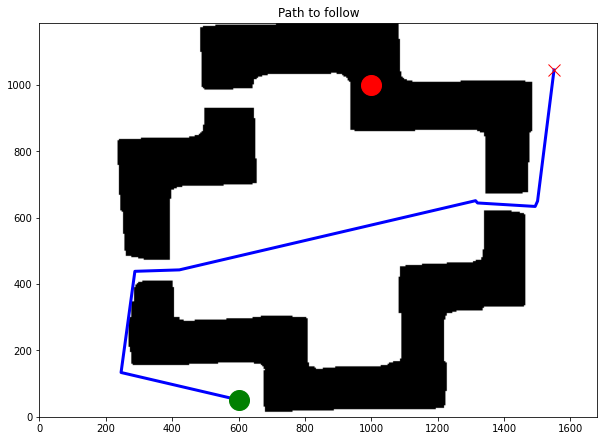

In [86]:
fig = plt.figure(figsize=(10,10))
_ ,_ = PathPlanning_online(graph_name, start, goal, savePath, RADIUS, True)
plt.plot(1000,1000, color = 'red', markersize=RADIUS/2 ,marker='o')
plt.show()